In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import keras
import time
import pandas as pd
import tensorflow as tf
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.models import Model, Sequential
import datetime

In [2]:
basedir = os.path.join(os.getcwd())
print(basedir)
TRAIN_PATH = os.path.join(basedir, 'static', 'dataset')
print(TRAIN_PATH)

if not os.path.exists(TRAIN_PATH):
  print("Dataset not found")
else:
  print("Dataset found")

d:\Project\Semester 5\doorlock-flask
d:\Project\Semester 5\doorlock-flask\static\dataset
Dataset found


In [3]:
# Dapatkan tanggal dan waktu saat ini
now = datetime.datetime.now()

# Format tanggal dan waktu
formatted_date_time = now.strftime("%Y%m%d_%H%M%S")

# Cetak tanggal dan waktu
print(formatted_date_time)

20231125_173253


In [4]:
images = []
labels = []
for i in sorted(os.listdir(TRAIN_PATH)):
    print(f"Reading {i}...")
    for j in os.listdir(os.path.join(TRAIN_PATH, i)):
        img = cv2.imread(os.path.join(TRAIN_PATH, i, j))
        img = cv2.resize(img, (224, 224))
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        images.append(img)
        labels.append(i)

print("Selesai Membaca Dataset")
print(f"Total Data Gambar Seluruh Kelas : {len(images)}")

Reading Fara-Mahasiswa...
Reading Fathan-Mahasiswa...
Reading Krisna-Mahasiswa...
Reading Prof-Mahasiswa...
Selesai Membaca Dataset
Total Data Gambar Seluruh Kelas : 400


In [30]:
def augmentasi_gambar(img):
  h, w = img.shape[:2]
  center = (w//2, h//2)
  rotate_10 = cv2.getRotationMatrix2D(center, 10, 1.0)
  rotate_neg_10 = cv2.getRotationMatrix2D(center, -10, 1.0)
  rotate_15 = cv2.getRotationMatrix2D(center, 15, 1.0)
  rotate_neg_15 = cv2.getRotationMatrix2D(center, -15, 1.0)
  # trans_x_10 = np.float32([[1, 0, 10], [0, 1, 0]])
  # trans_x_10_neg = np.float32([[1, 0, -10], [0, 1, 0]])
  # trans_y_10 = np.float32([[1, 0, 0], [0, 1, 10]])
  # trans_y_10_neg = np.float32([[1, 0, 0], [0, 1, -10]])

  imgs = []
  for i in range(10, 80, 20):
        bright_img = cv2.convertScaleAbs(img, beta=i)
        imgs.append(bright_img)
  imgs.extend([
    cv2.warpAffine(img, rotate_10, (w, h), borderValue=(255, 255, 255)),
    cv2.warpAffine(img, rotate_neg_10, (w, h), borderValue=(255, 255, 255)),
    cv2.warpAffine(img, rotate_15, (w, h), borderValue=(255, 255, 255)),
    cv2.warpAffine(img, rotate_neg_15, (w, h), borderValue=(255, 255, 255)),
    # cv2.warpAffine(img, trans_x_10, (w, h), borderValue=(255, 255, 255)),
    # cv2.warpAffine(img, trans_x_10_neg, (w, h), borderValue=(255, 255, 255)),
    # cv2.warpAffine(img, trans_y_10, (w, h), borderValue=(255, 255, 255)),
    # cv2.warpAffine(img, trans_y_10_neg, (w, h), borderValue=(255, 255, 255)),
    cv2.add(img, 20),
    cv2.add(img, 30)
  ])

  return imgs

10


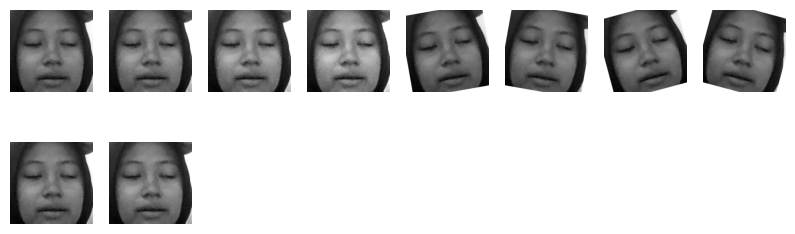

In [31]:
img_test = images[0]
print(len(augmentasi_gambar(img_test)))
import matplotlib.pyplot as plt
augmented_image_test = augmentasi_gambar(img_test)
plt.figure(figsize=(10, 10))
for i, img in enumerate(augmented_image_test):
    plt.subplot(6, 8, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')  # Menonaktifkan sumbu
plt.show()

In [32]:
augmented_images = []
augmenter_labels = []
for i , img in enumerate(images):
  try:
    augmented_images.extend(augmentasi_gambar(img))
    augmenter_labels.extend([labels[i]]*10)
  except:
    print("Error", i)

len(augmented_images), len(augmenter_labels)
images.extend(augmented_images)
labels.extend(augmenter_labels)

('Fara-Mahasiswa', 1100)
('Fathan-Mahasiswa', 1100)
('Indra-Mahasiswa', 1100)
('Krisna-Mahasiswa', 1100)
('Prof-Mahasiswa', 1100)


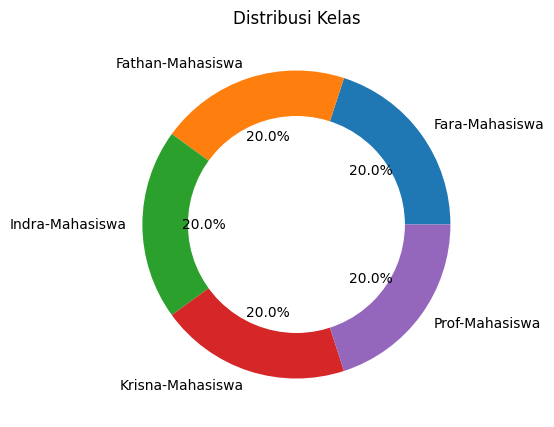

In [33]:
unique, counts = np.unique(labels, return_counts=True)
for item in zip(unique, counts):
    print(item)
unique = np.unique(labels)
label_distr = {i:labels.count(i) for i in labels}.values()
plt.figure(figsize=(10,5))
circle = plt.Circle((0,0), 0.7, color="white")
plt.title("Distribusi Kelas")
plt.pie(label_distr, labels=unique, autopct='%1.1f%%')
p = plt.gcf().gca().add_artist(circle)
plt.show()

In [34]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
le = LabelEncoder()
le.fit(labels)
names = le.classes_
name_vec = le.transform(labels)
categorical_name_vec = to_categorical(name_vec)
print("Jumlah Kelas : ", len(names))
print(names)
print(len(categorical_name_vec))

Jumlah Kelas :  5
['Fara-Mahasiswa' 'Fathan-Mahasiswa' 'Indra-Mahasiswa' 'Krisna-Mahasiswa'
 'Prof-Mahasiswa']
5500


In [35]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=42)
print(f"Jumlah Data Train : {len(x_train)}")
print(f"Jumlah Data Test : {len(x_test)}")
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(names))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(names))
y_train = np.array(y_train)
X_train = np.array(x_train)
y_test = np.array(y_test)
X_test = np.array(x_test)
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)
print(images[1000].shape)

Jumlah Data Train : 4400
Jumlah Data Test : 1100
X_train Shape:  (4400, 224, 224)
X_test Shape:  (1100, 224, 224)
y_train Shape:  (4400, 5)
y_test Shape:  (1100, 5)
(224, 224)


In [37]:
# MODEL CNN-1
model = Sequential([
  Conv2D(128, (3,3), activation='relu', input_shape=(224, 224, 1)),
  MaxPooling2D(2,2),
  Conv2D(32, (3,3), activation='relu'),
  MaxPooling2D(2,2),
  Conv2D(64, (3,3), activation='relu'),
  MaxPooling2D(2,2),
  Dropout(0.25),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(64, activation='relu'),
  Dropout(0.5),
  Dense(len(names), activation='softmax'),
  # Dense(len(names) + 1, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 222, 222, 128)     1280      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 111, 111, 128)     0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 109, 109, 32)      36896     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 54, 54, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 26, 26, 64)       

In [38]:
# TRAIN USING CNN-1 (CUSTOM LAYER)
EPOCHS = 10
STEP_PER_EPOCH = 20
BATCH_SIZE = 32
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), steps_per_epoch=STEP_PER_EPOCH, batch_size=BATCH_SIZE)

Epoch 1/10
20/20 [==============================] - 115s 5s/step - loss: 8.0217 - accuracy: 0.2750 - val_loss: 1.4470 - val_accuracy: 0.3555
Epoch 2/10
20/20 [==============================] - 91s 5s/step - loss: 1.2493 - accuracy: 0.5000 - val_loss: 0.8185 - val_accuracy: 0.7300
Epoch 3/10
20/20 [==============================] - 92s 5s/step - loss: 0.9426 - accuracy: 0.6328 - val_loss: 0.3054 - val_accuracy: 0.9364
Epoch 4/10
20/20 [==============================] - 91s 5s/step - loss: 0.5513 - accuracy: 0.7937 - val_loss: 0.1391 - val_accuracy: 0.9727
Epoch 5/10
20/20 [==============================] - 92s 5s/step - loss: 0.3745 - accuracy: 0.8703 - val_loss: 0.0780 - val_accuracy: 0.9718
Epoch 6/10
20/20 [==============================] - 97s 5s/step - loss: 0.2421 - accuracy: 0.9062 - val_loss: 0.0538 - val_accuracy: 0.9873
Epoch 7/10
20/20 [==============================] - 92s 5s/step - loss: 0.1826 - accuracy: 0.9391 - val_loss: 0.0277 - val_accuracy: 0.9909
Epoch 8/10
20/20 [=

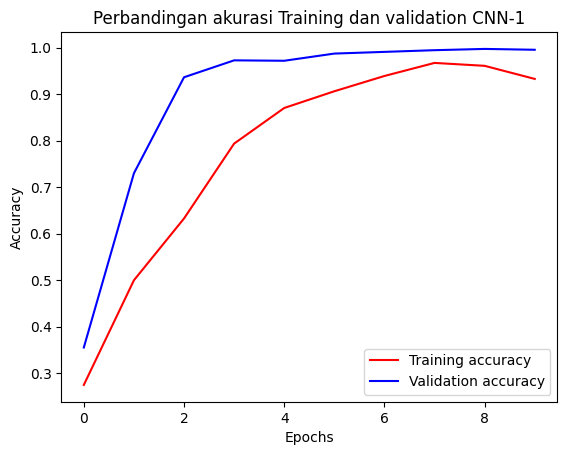

<Figure size 640x480 with 0 Axes>

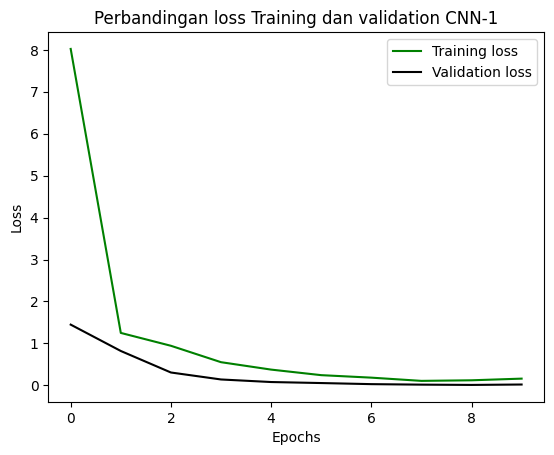

<Figure size 640x480 with 0 Axes>

In [39]:
# ACCURACY AFTER USING CNN-1
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Perbandingan akurasi Training dan validation CNN-1')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'k', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Perbandingan loss Training dan validation CNN-1')
plt.legend(loc=0)
plt.figure()
plt.show()

In [40]:
# TESTING TRAIN'S MODEL
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

35/35 [==============================] - 27s 763ms/step


In [41]:
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix


def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.0
    cm = np.round(cm, 2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

35/35 [==============================] - 23s 651ms/step
Test Accuracy = 1.00


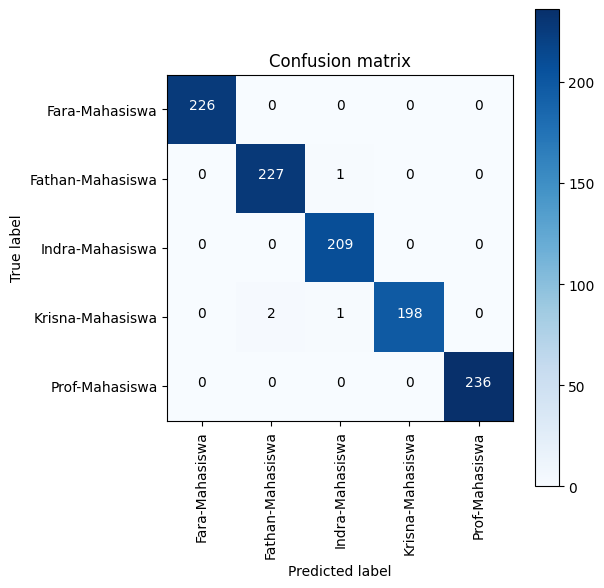

In [42]:
predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in predictions]

y_true = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_true, y_pred)
cm = plot_confusion_matrix(confusion_mtx, classes = names, normalize=False)

In [43]:
model.save('static/models/model_cnn1_251123_5_gray.h5')

c:\Users\fthnm\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
